In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image, ImageDraw
import glob
import random
import cv2
from tqdm.notebook import tqdm
import numpy as np
import sys

# Add utils path
sys.path.append('../')
from project_utils import helpers as H
H.expand_jupyter_screen()


# Need to make annotations for non-face wearing people
So at first I tried to not do this and just train the model as is. The result of this was the model learned to detect `valid_mask`, `with_mask` and `cell_phone`, but did absolutely terible on `without_mask`. The reason for this is in all likelihood due to the model getting very confused about all the faces without masks there's present in `cell_phone` images which is not annotated as `without_mask`. After thinking about how to deal with this without starting all over, I figured why not just automatically annotate all the faces present in all the `cell_phone` images? The change some of them has faces with masks are very slim (dataset made much before covid19).

# File setup

In [18]:
# Get all the image and annotation paths
dataset_path = "C:/Users/JK/Desktop/datasets/coco_cell_phone/"
image_paths = glob.glob( dataset_path + "images/*/*" )
anno_paths = glob.glob( dataset_path + "labels/*/*" )

# Extract all file names with paths or file extensions
anno_names = [H.extract_file_name(anno_path) for anno_path in anno_paths]
image_names = [H.extract_file_name(image_path) for image_path in image_paths]

# Check 1: there's the same number of annotations as there are images
assert len(anno_names)==len(image_names)

# Check 2: The annotation folder contain the same files (i.e. file name) as the image folder
assert sum([anno_name in image_names for anno_name in anno_names]) == len(anno_names)

# Model setup
Face detection model from: https://github.com/timesler/facenet-pytorch

In [3]:
mtcnn = MTCNN(image_size=1024, device="cuda", keep_all=True)
resnet = InceptionResnetV1(pretrained='vggface2').eval().cuda()

# Sanity check
Detect and draw faces from the non-annotated `cell_phone` images. Ran it a lot of times, seems pretty robust, but still fails quite often.

In [24]:
Image.open(image_path).size

(640, 480)

[421.39837646484375, 107.30793762207031, 463.9215393066406, 160.38168334960938]
C:/Users/JK/Desktop/datasets/coco_cell_phone/images\train\coco_cell_phone_000000324713.jpg


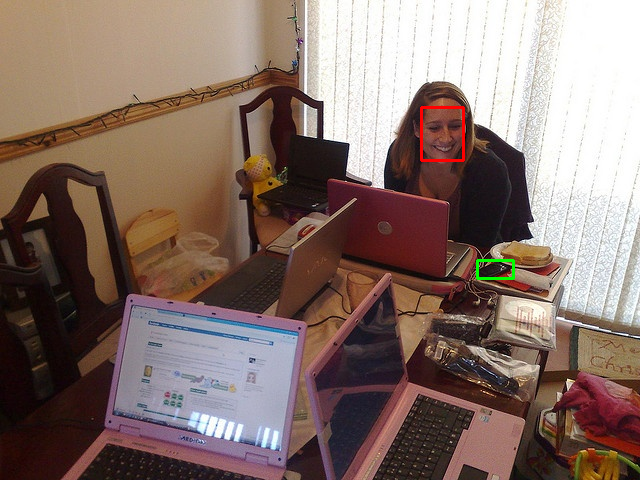

In [55]:
np.random.seed(0)
for index in np.random.choice( np.arange(len(image_paths)), 2):
    image_path = image_paths[index]
    anno_path = anno_paths[index]
    
    image = H.yolo_draw_bbs_path(image_path, anno_path, (0, 255, 0))
    boxes, _ = mtcnn.detect(image)
    if boxes is None:
        continue
    
    for box in boxes:
        x1, y1, x2, y2 = [int(n) for n in box.tolist()]
        print(box.tolist())
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)  
    
    print(path)
    cv2.imwrite("combined_dataset_example.png", image)
    display(H.cv2_image_to_pillow(image))
    

# Check conversion to YOLO-format work as expected

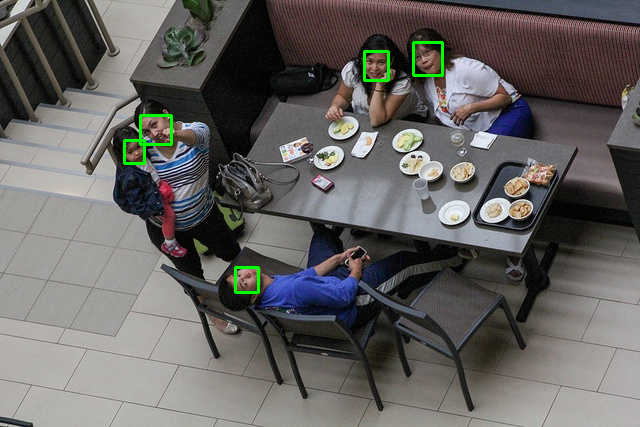

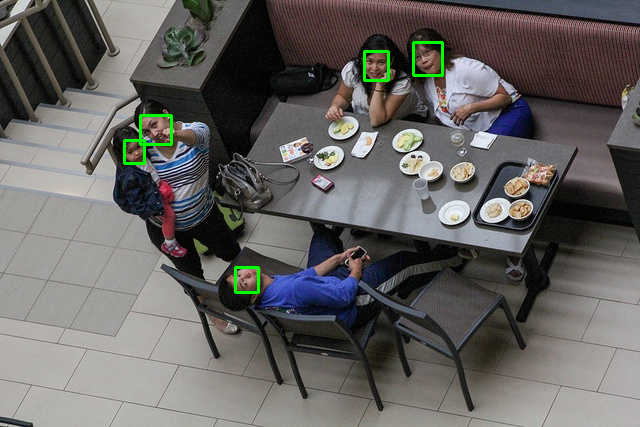

In [5]:
img = Image.open(image_paths[-1])

bbs, _ = mtcnn.detect(img)
image = H.pillow_image_to_cv2(img)
for bb in bbs:
    x1,y1,x2,y2 = [int(n) for n in bb]
    cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
H.cv2_show_image(image)

image = H.pillow_image_to_cv2(img)
for bb in bbs:
    yolo_format_string = H.normal_bb_coordinates_to_yolo_format(bb, img.size[0], img.size[1], 1)
    x, y, w, h = [float(n) for n in yolo_format_string.split()[1:]]
    H.yolo_draw_single_bb_cv2(image, x, y, w, h, (0,255,0))
H.cv2_show_image(image)

# Add `without_mask` annotations to detected faces within all `cell_phone` images

In [6]:
# Mappings to make my life easier
file_names, name_to_image_path, name_to_anno_path = [], {}, {}
for i in range(len(image_paths)):
    anno_path = anno_paths[i]
    anno_name = H.extract_file_name(anno_path)
    image_path = image_paths[i]
    image_name = H.extract_file_name(image_path)
    assert image_name == anno_name
    shared_file_name = image_name
    file_names.append(shared_file_name)
    
    name_to_image_path[shared_file_name] = image_path
    name_to_anno_path[shared_file_name] = anno_path

# Add/update `cell_phone` annotations to include faces. the class `without_mask` has label: 1
for file_name in tqdm(file_names):
    anno_path = name_to_anno_path[file_name]
    already_existing_anno =  H.read_txt_file(name_to_anno_path[file_name])
    img = Image.open( name_to_image_path[file_name] )
    
    bbs, _ = mtcnn.detect(img)
    if bbs is not None:
        anno_string_to_add = "\n" if already_existing_anno[-1] != "\n" else ""
        for bb in bbs:
            yolo_format_string = H.normal_bb_coordinates_to_yolo_format(bb, img.size[0], img.size[1], 1)
            anno_string_to_add += yolo_format_string + "\n"
        H.write_to_file(anno_path, anno_string_to_add[:-1])

  0%|          | 0/4880 [00:00<?, ?it/s]